# Phenotype Dataset Analysis

### Package Import and Path Configuration
This section imports all required packages and defines the file paths needed for the analysis.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from helpers.readFiles import load_tsv, load_csv
from helpers.processDataframes import (na_elimination, 
                                       impute_by_disease, 
                                       get_highly_correlated_columns_from_matrix, 
                                       eliminate_fields_by_fieldID, 
                                       remove_outliers_and_align_datasets, 
                                       rename_columns_with_field_names, 
                                       rename_onehot_columns,
                                       merge_dataframes_on_eid)
from helpers.vizualization import (create_boxplots, 
                                   correlation_matrix_spearman, 
                                   correlation_matrix_crammer, 
                                   create_histograms, 
                                   visualize_correlation_matrix)
from helpers.oneHotEncoding import (onehot_encode_simple_nominal, 
                                    onehot_encode_multiple_nominal)
from helpers.scaleDataFrame import scale_numeric_columns

# Set the path to the directory containing the raw data files
inputpath = "../main/data/UK_BIOBANK_DATA" 
path_graphs = "../main/doutputs/graphs" 
path_results = "../main/doutputs/results" 
path_outputs = "/outputs"

The touchscreen dataset is loaded. This dataset is provided with a tab separator format. For that reason, the following code was used.

In [2]:
#Charge dataframes
#Touchscreen
phenotype_df = load_tsv("phenotype_data.tsv", inputpath)

# Display the first few rows of the touchscreen data
phenotype_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/phenotype_data.tsv
File loaded: 502180 rows × 156 columns


,f_eid,f_1239_0_0,f_1239_2_0,f_1249_0_0,f_1249_2_0,f_1259_0_0,f_1259_2_0,f_1269_0_0,f_1269_2_0,f_1279_0_0,...,f_22035_0_0,f_22035_2_0,f_22036_0_0,f_22036_2_0,f_22037_0_0,f_22037_2_0,f_22038_0_0,f_22038_2_0,f_22039_0_0,f_22039_2_0
0,1000012,0.0,NaN,4.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,0.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,...,1.0,NaN,1.0,NaN,3564.0,NaN,4320.0,NaN,320.0,NaN
2,1000035,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,1000044,0.0,NaN,2.0,NaN,1.0,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,99.0,NaN,0.0,NaN,0.0,NaN
4,1000053,0.0,NaN,3.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,NaN,1.0,NaN,693.0,NaN,240.0,NaN,0.0,NaN


The chars dataset is loaded, which contains information relevant to the original dataset. This is done to gain more information, better understand the dataset, and make future associations.

In [3]:
phenotype_chars_df = load_tsv("phenotype_chars.tsv", inputpath, skiprows=5)

phenotype_chars_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/phenotype_chars.tsv
File loaded: 87 rows × 17 columns


,Field,FieldID,ValueType,Coding,Category,Participants,Items,Stability,Units,ItemType,Strata,Sexed,Instances,Array,Notes,Link,Path
0,Current tobacco smoking,1239,Categorical single,100347.0,100058,501500,597678,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Do you smoke toba...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=...,Assessment centre > Touchscreen > Lifestyle an...
1,Past tobacco smoking,1249,Categorical single,100348.0,100058,464200,556298,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""In the past, how ...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=...,Assessment centre > Touchscreen > Lifestyle an...
2,Smoking/smokers in household,1259,Categorical single,100370.0,100058,461855,552928,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Does anyone in yo...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=...,Assessment centre > Touchscreen > Lifestyle an...
3,Exposure to tobacco smoke at home,1269,Integer,100291.0,100058,464571,556698,Complete,hours/week,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""At home, about ho...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=...,Assessment centre > Touchscreen > Lifestyle an...
4,Exposure to tobacco smoke outside home,1279,Integer,100291.0,100058,464571,556698,Complete,hours/week,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Outside of your h...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=...,Assessment centre > Touchscreen > Lifestyle an...


Load the file containing the codes of the categorical questions

In [4]:
phenotype_cbkeys_df = load_tsv("phenotype_cbkeys.tsv",inputpath)

phenotype_cbkeys_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/phenotype_cbkeys.tsv
File loaded: 244 rows × 6 columns


,coding_name,code,meaning,concept,display_order,parent_code
0,7,1,Yes,NaN,1,NaN
1,7,0,No,NaN,2,NaN
2,100291,-1,Do not know,NaN,1,NaN
3,100291,-3,Prefer not to answer,NaN,2,NaN
4,100347,1,"Yes, on most or all days",NaN,1,NaN


The tests were conducted in three (3) stages. Across these stages, only instances 0 and 1 were retained, because this stage contains the least amount of missing data.

In [7]:
# Select columns that match the pattern 'f_\d+_0_\d+' and include 'eid'
# _instances_array 
# instances cohort 
# array number of options 

selected_columns = ['f_eid'] + [
    col for col in phenotype_df.columns
    if re.match(r'^f_\d+_0_\d+$', col)
]

# Create a new DataFrame with the selected columns
phenotype_dr_df = phenotype_df[selected_columns]

phenotype_dr_df.head()

,f_eid,f_1239_0_0,f_1249_0_0,f_1259_0_0,f_1269_0_0,f_1279_0_0,f_1289_0_0,f_1299_0_0,f_1309_0_0,f_1319_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
0,1000012,0.0,4.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,...,NaN,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.712500,1001.0,2.0,16.0,370.0,1.0,1.0,3564.0,4320.0,320.0
2,1000035,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.462963,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000044,0.0,2.0,1.0,0.0,0.0,8.0,8.0,4.0,0.0,...,NaN,1001.0,0.0,2.0,15.0,0.0,0.0,99.0,0.0,0.0
4,1000053,0.0,3.0,0.0,0.0,0.0,3.0,2.0,2.0,-10.0,...,NaN,1001.0,1.0,10.0,50.0,0.0,1.0,693.0,240.0,0.0


Selection of specific columns 

In [14]:
columns_to_keep = ['f_eid', 'f_1438_0_0', 'f_1289_0_0', 'f_1488_0_0', 'f_1568_0_0', 'f_1458_0_0', 'f_1309_0_0', 'f_1478_0_0', 'f_1369_0_0'] 

new_df = phenotype_dr_df[columns_to_keep]

new_df.head()

,f_eid,f_1438_0_0,f_1289_0_0,f_1488_0_0,f_1568_0_0,f_1458_0_0,f_1309_0_0,f_1478_0_0,f_1369_0_0
0,1000012,6.0,2.0,4.0,0.0,4.0,0.0,2.0,1.0
1,1000021,8.0,2.0,-10.0,0.0,3.0,0.0,2.0,1.0
2,1000035,20.0,0.0,10.0,0.0,2.0,0.0,1.0,0.0
3,1000044,28.0,8.0,2.0,NaN,0.0,4.0,2.0,1.0
4,1000053,18.0,3.0,2.0,3.0,0.0,2.0,1.0,1.0


In [15]:
# Casos especiales por FieldID
field_replacements = {
    '3710': { -2: 3 },
    '4014': { -2: 3 },  
    '1518': { -2: 4 }
}

# Valores generales
general_replace = { -10: 0.5 }
na_values = [-27, -23, -21, -17, -13, -7, -5, -4, -3, -1, -11]

for col in new_df.columns:
    if col != 'eid':
        new_df[col] = new_df[col].replace(general_replace)
        new_df[col] = new_df[col].replace(na_values, np.nan)

        match = re.match(r'f_(\d+)_\d+_\d+', col)
        if match:
            field_id = match.group(1)
            if field_id in field_replacements:
                new_df[col] = new_df[col].replace(field_replacements[field_id])

new_df.head()

/tmp/ipykernel_34154/2210729155.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].replace(general_replace)
/tmp/ipykernel_34154/2210729155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].replace(na_values, np.nan)


,f_eid,f_1438_0_0,f_1289_0_0,f_1488_0_0,f_1568_0_0,f_1458_0_0,f_1309_0_0,f_1478_0_0,f_1369_0_0
0,1000012,6.0,2.0,4.0,0.0,4.0,0.0,2.0,1.0
1,1000021,8.0,2.0,0.5,0.0,3.0,0.0,2.0,1.0
2,1000035,20.0,0.0,10.0,0.0,2.0,0.0,1.0,0.0
3,1000044,28.0,8.0,2.0,NaN,0.0,4.0,2.0,1.0
4,1000053,18.0,3.0,2.0,3.0,0.0,2.0,1.0,1.0


In [16]:
renamed_df = rename_columns_with_field_names(new_df, phenotype_chars_df)

renamed_df.head()

No coincide con patrón: f_eid


,f_eid,Bread intake,Cooked vegetable intake,Tea intake,Average weekly red wine intake,Cereal intake,Fresh fruit intake,Salt added to food,Beef intake
0,1000012,6.0,2.0,4.0,0.0,4.0,0.0,2.0,1.0
1,1000021,8.0,2.0,0.5,0.0,3.0,0.0,2.0,1.0
2,1000035,20.0,0.0,10.0,0.0,2.0,0.0,1.0,0.0
3,1000044,28.0,8.0,2.0,NaN,0.0,4.0,2.0,1.0
4,1000053,18.0,3.0,2.0,3.0,0.0,2.0,1.0,1.0


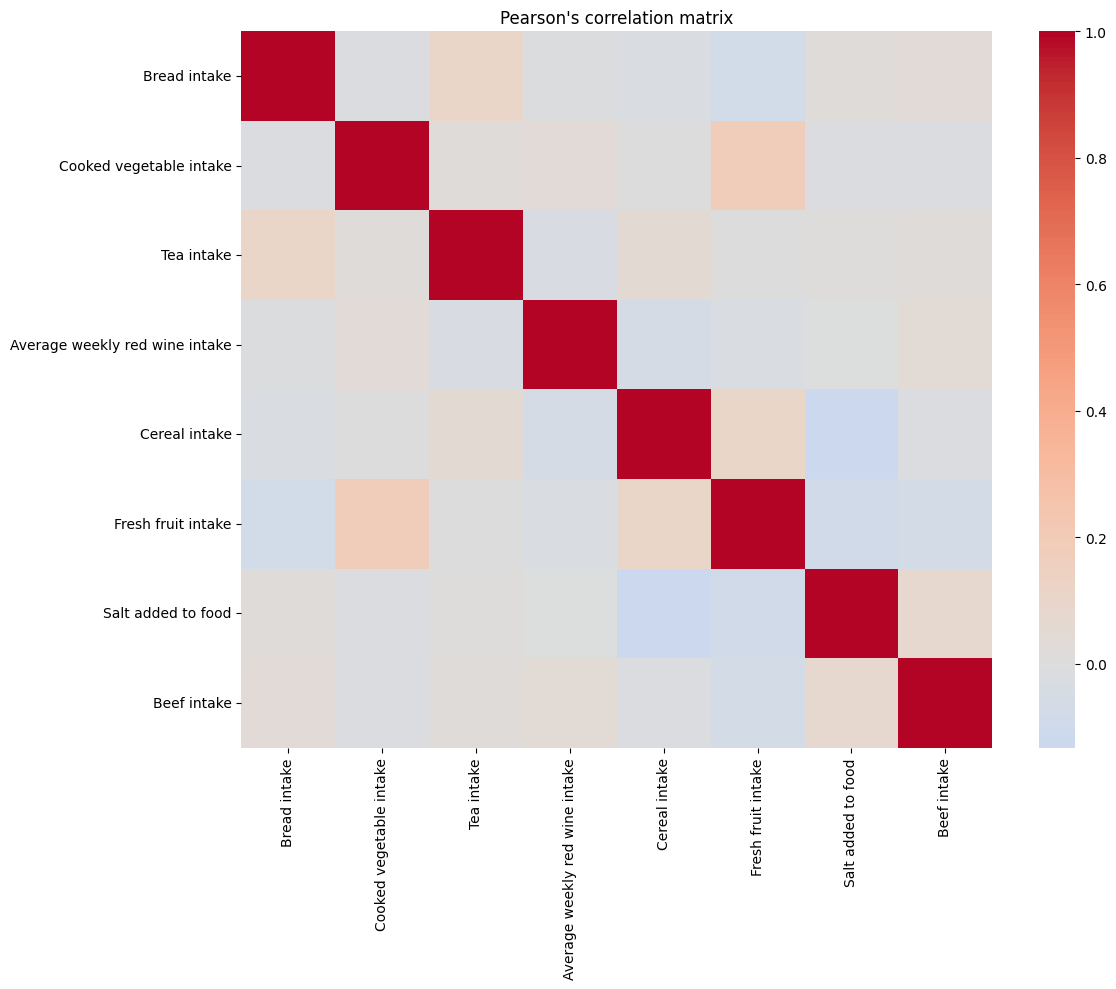

In [18]:
correlation_matrix= renamed_df.drop(columns='f_eid').corr()

visualize_correlation_matrix(correlation_matrix, 
                             title="Pearson's correlation matrix", 
                             center=0)

In [19]:
get_highly_correlated_columns_from_matrix(correlation_matrix, 
                                          phenotype_chars_df ,
                                          threshold=0.6)


Pairs found with correlation > 0.6: 0
No pairs were found with correlation above the threshold.


In [22]:
#CategoricalSimple
categorical_collumns = ['f_eid', 'f_1478_0_0', 'f_1369_0_0']

categorical_simple_df = new_df[categorical_collumns]

categorical_simple_df  = categorical_simple_df.rename(
    columns={'f_eid': 'eid'})

categorical_simple_onehot_df = onehot_encode_simple_nominal(
    categorical_simple_df, 
    phenotype_chars_df, 
    phenotype_cbkeys_df)

categorical_simple_onehot_df.head()

,eid,f_1478_100394_1,f_1478_100394_2,f_1478_100394_3,f_1478_100394_4,f_1369_100377_0,f_1369_100377_1,f_1369_100377_2,f_1369_100377_3,f_1369_100377_4,f_1369_100377_5
0,1000012,0,1,0,0,0,1,0,0,0,0
1,1000021,0,1,0,0,0,1,0,0,0,0
2,1000035,1,0,0,0,1,0,0,0,0,0
3,1000044,0,1,0,0,0,1,0,0,0,0
4,1000053,1,0,0,0,0,1,0,0,0,0


In [23]:
categorical_renamed = rename_onehot_columns(
    categorical_simple_onehot_df, 
    phenotype_chars_df, 
    phenotype_cbkeys_df)

categorical_renamed.head()

,eid,Salt added to food: Never/rarely,Salt added to food: Sometimes,Salt added to food: Usually,Salt added to food: Always,Beef intake: Never,Beef intake: Less than once a week,Beef intake: Once a week,Beef intake: 2-4 times a week,Beef intake: 5-6 times a week,Beef intake: Once or more daily
0,1000012,0,1,0,0,0,1,0,0,0,0
1,1000021,0,1,0,0,0,1,0,0,0,0
2,1000035,1,0,0,0,1,0,0,0,0,0
3,1000044,0,1,0,0,0,1,0,0,0,0
4,1000053,1,0,0,0,0,1,0,0,0,0


In [24]:
#numerical values

numeric_colums =['f_eid', 'f_1438_0_0', 'f_1289_0_0', 'f_1488_0_0', 'f_1568_0_0', 'f_1458_0_0', 'f_1309_0_0'] 


numeric_colums_df = new_df[numeric_colums]

numeric_colums_df.head()

,f_eid,f_1438_0_0,f_1289_0_0,f_1488_0_0,f_1568_0_0,f_1458_0_0,f_1309_0_0
0,1000012,6.0,2.0,4.0,0.0,4.0,0.0
1,1000021,8.0,2.0,0.5,0.0,3.0,0.0
2,1000035,20.0,0.0,10.0,0.0,2.0,0.0
3,1000044,28.0,8.0,2.0,NaN,0.0,4.0
4,1000053,18.0,3.0,2.0,3.0,0.0,2.0


In [25]:
numeric_renamed_df = rename_columns_with_field_names(
    numeric_colums_df, 
    phenotype_chars_df)
numeric_renamed_df.head()

No coincide con patrón: f_eid


,f_eid,Bread intake,Cooked vegetable intake,Tea intake,Average weekly red wine intake,Cereal intake,Fresh fruit intake
0,1000012,6.0,2.0,4.0,0.0,4.0,0.0
1,1000021,8.0,2.0,0.5,0.0,3.0,0.0
2,1000035,20.0,0.0,10.0,0.0,2.0,0.0
3,1000044,28.0,8.0,2.0,NaN,0.0,4.0
4,1000053,18.0,3.0,2.0,3.0,0.0,2.0


In [27]:
numeric_renamed_df = numeric_renamed_df.rename(
    columns={'f_eid': 'eid'})

phenotype_selected_df = pd.merge(
    categorical_renamed, 
    numeric_renamed_df, 
    on='eid', 
    how='inner'
)
phenotype_selected_df.head()

,eid,Salt added to food: Never/rarely,Salt added to food: Sometimes,Salt added to food: Usually,Salt added to food: Always,Beef intake: Never,Beef intake: Less than once a week,Beef intake: Once a week,Beef intake: 2-4 times a week,Beef intake: 5-6 times a week,Beef intake: Once or more daily,Bread intake,Cooked vegetable intake,Tea intake,Average weekly red wine intake,Cereal intake,Fresh fruit intake
0,1000012,0,1,0,0,0,1,0,0,0,0,6.0,2.0,4.0,0.0,4.0,0.0
1,1000021,0,1,0,0,0,1,0,0,0,0,8.0,2.0,0.5,0.0,3.0,0.0
2,1000035,1,0,0,0,1,0,0,0,0,0,20.0,0.0,10.0,0.0,2.0,0.0
3,1000044,0,1,0,0,0,1,0,0,0,0,28.0,8.0,2.0,NaN,0.0,4.0
4,1000053,1,0,0,0,0,1,0,0,0,0,18.0,3.0,2.0,3.0,0.0,2.0


In [28]:
phenotype_selected_df.to_csv(os.path.join(inputpath, "selectedphenotype.tsv"), sep="\t", index=False)

Exception ignored in: <function ResourceTracker.__del__ at 0x7ff2ae894540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe44be90540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7ff9b5588540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip